<a href="https://colab.research.google.com/github/salexey1990/gb/blob/master/ml-business/hw02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from google.colab import files
import io

# 1

In [8]:
uploaded = files.upload()

Saving my_PJME_MW.csv to my_PJME_MW.csv


In [0]:
df = pd.read_csv(io.BytesIO(uploaded['my_PJME_MW.csv']), index_col=[0], parse_dates=[0])

In [11]:
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [0]:
# функция разбиения датасета на тестовую и валидационную выборки 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()


In [0]:
# функция экспоненциального сглаживания датасета
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [0]:
# функция для подсчёта ошибки модели
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Добавим в наши данные экспоненциально сглаженные значения потребления энергии для того, чтобы найти тренд сезонности, и взглянем как они выглядят

In [0]:
df['exp_0_01'] = exponential_smoothing(df['PJME_MW'], 0.01)

In [31]:
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,exp_0_01
Date,,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0,30393.000000
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0,30381.720000
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0,30361.472800
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0,30336.848072
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0,30314.049591


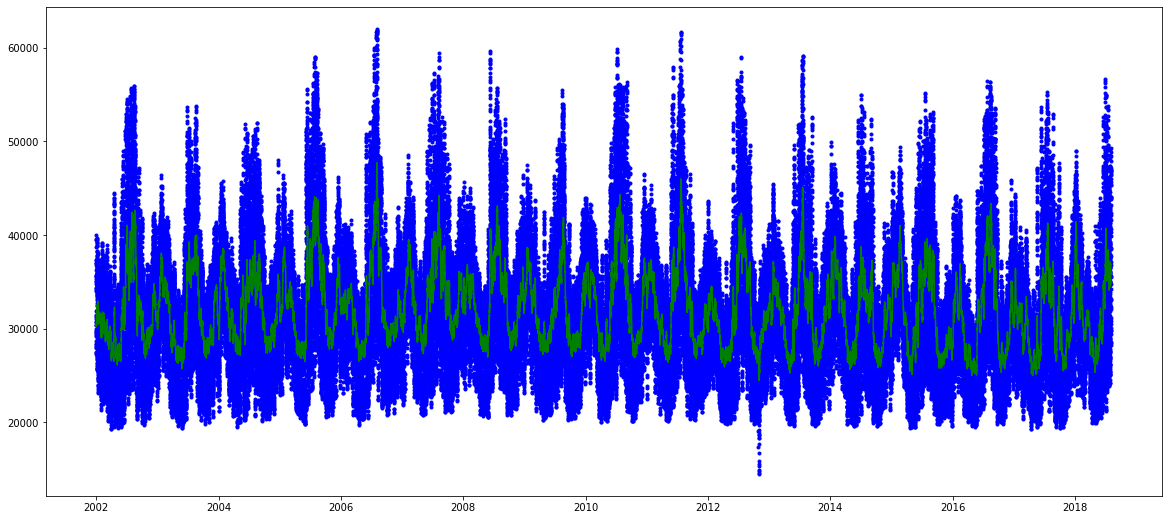

In [19]:
plt.figure(figsize=(20, 9))
plt.plot(df.index, df['PJME_MW'].values, '.b',label='исходный ряд')

plt.plot(df.index,df['exp_0_01'].values, color = 'green', label="экспоненциальное сглаживанию");

Теперь построим модели, которые предсказывали бы нам тренд сезонности, найденный с помощью экспоненциального сглаживания. Созданим две модели с разным горизонтом прогноза. Но сперва добавим поля для авторегрессионной модели.

In [51]:
df['t'] = 0
df.iloc[1:,14]=df.iloc[:-1,13].values
df['t1']=0
df.iloc[2:,15]=df.iloc[:-2,13].values
df['t2']=0
df.iloc[3:,16]=df.iloc[:-3,13].values
df.fillna(0)
df = df.drop(['Time'], axis=1)
df.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,exp_0_01,t,t1,t2
Date,,,,,,,,,,,,,,,,
2002-01-01,30393.0,2002,1,1,1,1,1,1,1,1,0,0,30393.000000,0.000000,0.0000,0.00
2002-01-01,29265.0,2002,1,1,1,1,1,1,2,1,0,0,30381.720000,30393.000000,0.0000,0.00
2002-01-01,28357.0,2002,1,1,1,1,1,1,3,1,0,0,30361.472800,30381.720000,30393.0000,0.00
2002-01-01,27899.0,2002,1,1,1,1,1,1,4,1,0,0,30336.848072,30361.472800,30381.7200,30393.00
2002-01-01,28057.0,2002,1,1,1,1,1,1,5,1,0,0,30314.049591,30336.848072,30361.4728,30381.72


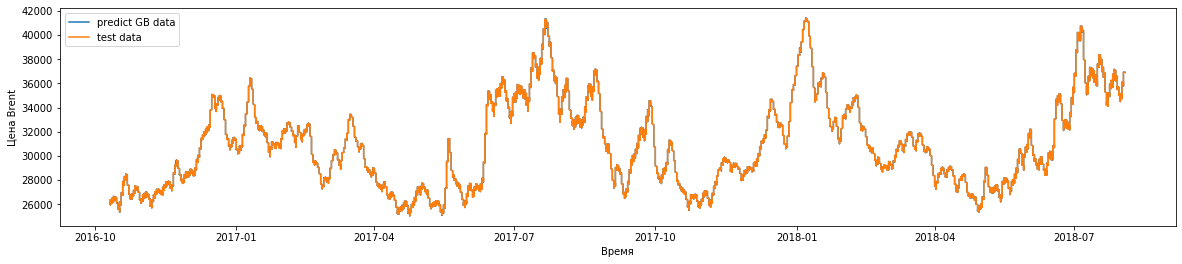

ошибка градиентного бустинга :   0.025372042309078687 %


In [55]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
train_b, test_b = split_data_b( df, '10-10-2016')

h=1
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[12]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[12]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

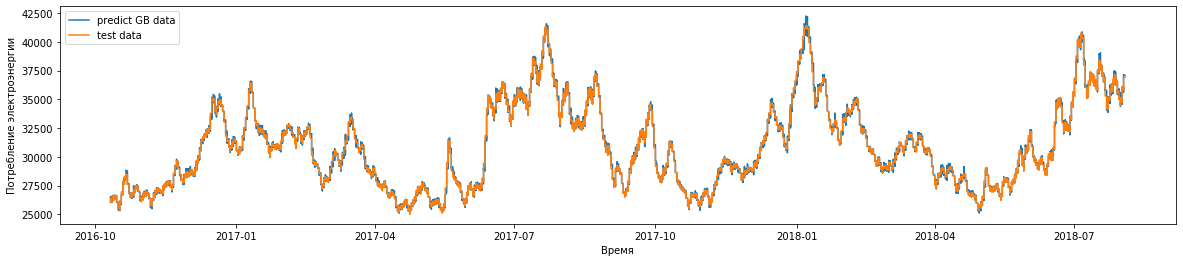

ошибка градиентного бустинга :   0.4367344507448529 %


In [56]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
train_b, test_b = split_data_b( df, '10-10-2016')

h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[12]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[12]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление электроэнергии')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Как видно, при изменении горизонта прогноза ошибка градиентного бустинга сильно вырасла с 0.0253% до 0.4367%. Очевидно, если мы хотим делать предсказания на ещё больший период времени вперёд, нам необходимо улучшать наши данные, возможно добавить большее количество исторических данных

# 4

а. Изменение температуры за окном безусловно не стационарный ряд, имеющий ярко выраженную цикличность как по часам, так и по сезонам. Кроме того, судя по всему имеют восходящй тренд глобального потепления=((. Хотя, в другой точке земного шара такая выраженная цикличность может и отсутствовать, что сделает ряд более похожим на стационарный

б. Количество денег потраченных в интернет магазине, конечно, силььно зависит от типа товаров, но чаще всего это не стационарный ряд, так как в подавляющем большинстве случаев присутствует цикличность (если мы продаём подарки, будут всплески в период праздников, если мы продаём лекарства, цикл будет связан с сезонами года). Хотя, продажи товаров повседневного назначения, таких как мыло и зубная паста, вполне могут быть стационарным рядом

в. Вес растущего котёнка имеет ярко выраженные тренд к возрастанию, с постепенным выходом на плато, так что не может быть стационарным рядом

г. Прирост объёма деревьев в лесу это очень долгий процесс, и скорее всего представляет собой стационарный ряд лишённый как циклов так и тренда. Конечно, если это не питомник, откуда деревья забирают при достижении их определённого размера.